# Data augmentation

As the segmentation data is scarse, a trick to have more avaibable annotated data is to use data augmentation. Data augmentation is also a way of teaching certain invariance to your machine learning algorithm.

In particular, for biomedical data it is interesting to have these invariance:
- Translation
- rotation 
- Miror
- Out of focus or bluriness (due to the scanner for instance)
- Elastic deformation

We will conclude with the creation of the generalized class that will contribute to the data augmentation

## Loading the toy data

In [1]:
%matplotlib inline
### Useful plotting function
def plot_comparison(original, modified, modification):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,16), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax1.set_adjustable('box-forced')
    ax2.imshow(modified, cmap=plt.cm.gray)
    ax2.set_title(modification)
    ax2.axis('off')
    ax2.set_adjustable('box-forced')

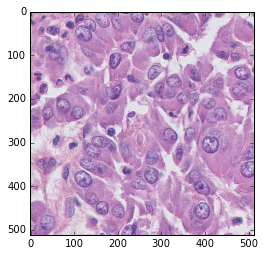

In [3]:
from skimage.io import imread
import matplotlib.pylab as plt


sample = imread('/Users/naylorpeter/Documents/Histopathologie/498959/RGB/10.png')
## It has fourth (useless) component
sample = sample[:,:,0:3]

plt.imshow(sample)
plt.show()

Each one of these transformation will have it's equivalent in a class transf.

In [4]:
import numpy as np

class Transf(object):
    
    def __init__(self,name):
        self.name = name
        
    def _apply_(self, image):
        raise NotImplementedError
        
    def enlarge(self,image, x, y):
        
        rows, cols, channels = image.shape
        
        enlarged_image = np.zeros(shape=(rows + 2 * y, cols + 2 * x, channels))
        
        enlarged_image[y:(y+rows),x:(x+cols), 0:channels] = image
        
        #top part:
        enlarged_image[0:y, x:(x+cols), 0:channels] = flip_horizontal(enlarged_image[y:(2 * y), x:(x+cols),0:channels])
        
        #bottom part:
        enlarged_image[(y+rows):(2 * y + rows), x:(x+cols),0:channels] = flip_horizontal(enlarged_image[rows:(y+rows), x:(x+cols),0:channels])

        #left part:
        enlarged_image[y:(y+rows), 0:x, 0:channels] = flip_vertical(enlarged_image[y:(y+rows), x:(2 * x),0:channels])
        
        #right part:
        enlarged_image[y:(y+rows), (cols + x):(2 * x + cols), 0:channels] = flip_vertical(enlarged_image[y:(y+rows), cols:(cols + x),0:channels])

        #top left from left part:
        enlarged_image[0:y, 0:x, 0:channels] = flip_horizontal(enlarged_image[y:(2 * y), 0:x, 0:channels])
        
        #top right from right part:
        enlarged_image[0:y, (x + cols):(2 * x + cols), 0:channels] = flip_horizontal(enlarged_image[y:(2 * y), cols:(x + cols), 0:channels])
        
        #bottom left from left part:
        enlarged_image[(y+rows):(2 * y + rows), 0:x, 0:channels] = flip_horizontal(enlarged_image[rows:(y + rows), 0:x, 0:channels])
        
        #bottom right from right part
        enlarged_image[(y+rows):(2 * y + rows), (x + cols):(2 * x + cols), 0:channels] = flip_horizontal(enlarged_image[rows:(y + rows), (x + cols):(2 * x + cols), 0:channels])
        enlarged_image = enlarged_image.astype('uint8')
        return(enlarged_image)


## Translation invariance

Translation is the shifting of object’s location. If you know the shift in $(x,y)$ direction, let it be $(t_x,t_y)$, you can create the transformation matrix $\textbf{M}$ as follows:


$$M = \begin{bmatrix} 1 & 0 & t_x \\ 0 & 1 & t_y \end{bmatrix}$$

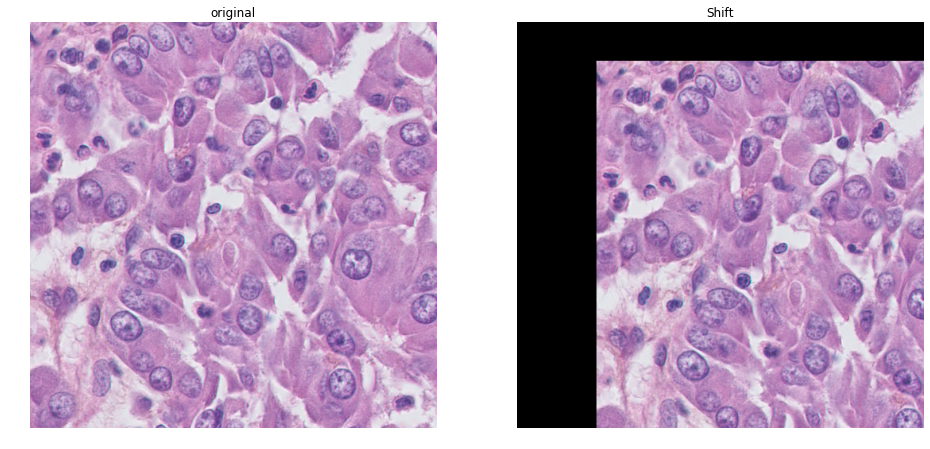

In [5]:
import cv2
import numpy as np

rows, cols, channels = sample.shape

M = np.float32([[1,0,100],[0,1,50]])
dst = cv2.warpAffine(sample,M,(cols,rows))
plot_comparison(sample, dst, "Shift")

# Rotation

Rotation of an image for an angle $\theta$ is achieved by the transformation matrix of the form

$$M = \begin{bmatrix} cos\theta & -sin\theta  \\ sin\theta & cos\theta \end{bmatrix}$$

But OpenCV provides scaled rotation with adjustable center of rotation so that you can rotate at any location you prefer. Modified transformation matrix is given by

$$\begin{bmatrix} \alpha & \beta & (1- \alpha ) \cdot center.x - \beta \cdot center.y \\ - \beta & \alpha & \beta \cdot center.x + (1- \alpha ) \cdot center.y \end{bmatrix}$$

where:

$$\begin{array}{l} \alpha = scale \cdot \cos \theta , \\ \beta = scale \cdot \sin \theta \end{array}$$

To find this transformation matrix, OpenCV provides a function, cv2.getRotationMatrix2D. Check below example which rotates the image by 90 degree with respect to center without any scaling.

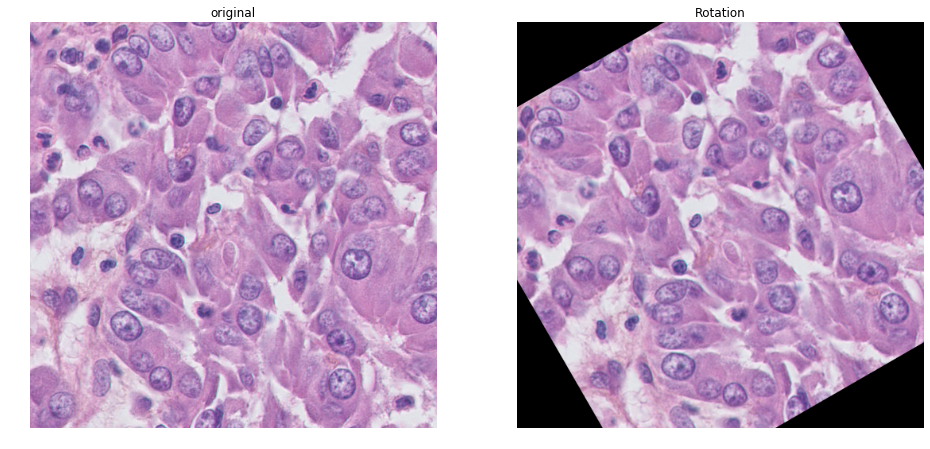

In [6]:
M = cv2.getRotationMatrix2D((cols/2,rows/2),30,1)
dst = cv2.warpAffine(sample,M,(cols,rows))

plot_comparison(sample, dst, "Rotation")

## Mirror

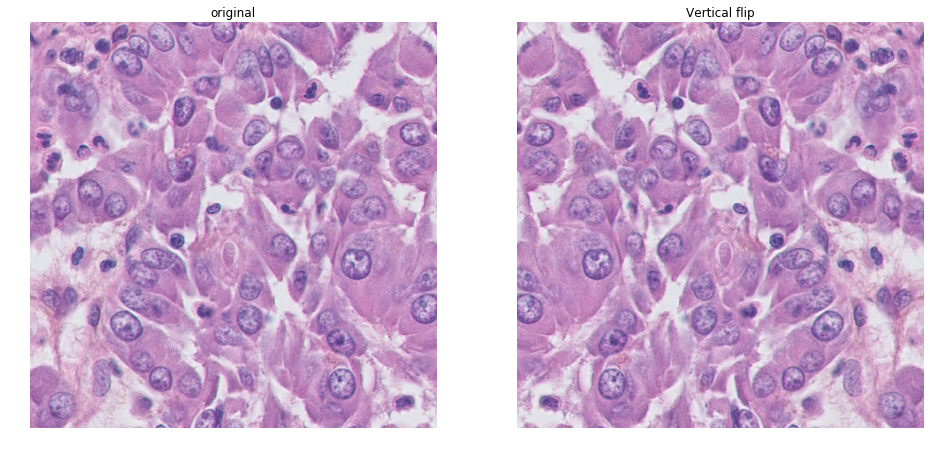

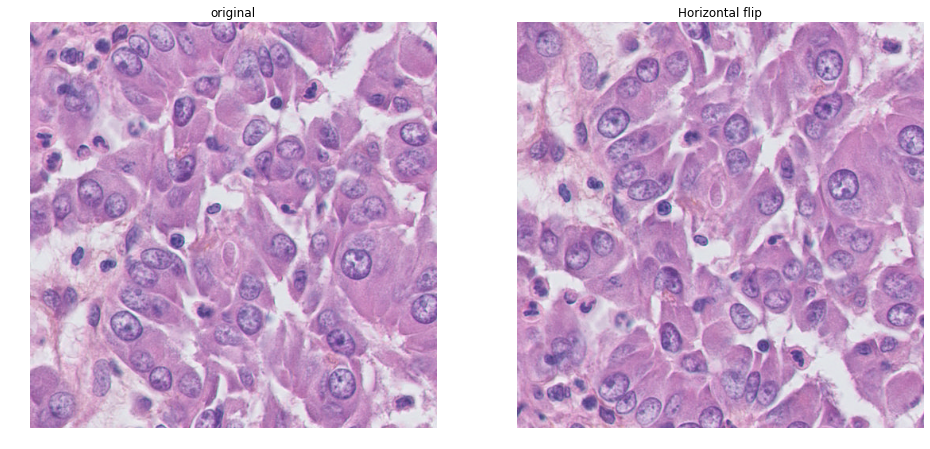

In [7]:
def flip_vertical(picture):
    result = picture.copy()
    height, width , channel= result.shape
    
    for x in range(0, width/2):   # Only process the half way
        for y in range(0, height):
        # swap pix and pix2
            #print [y, width  - x]
            result[y, width  - x - 1,  :] = picture[y, x, :]
            result[y, x, :] = picture[y, width - x - 1, :]
    return result

def flip_horizontal(picture):
    result = picture.copy()
    height, width , channel= result.shape
    
    for y in range(0, height/2):   # Only process the half way
        for x in range(0, width):
        # swap pix and pix2
            #print [y, width  - x]
            result[y, x,  :] = picture[height - 1 - y, x, :]
            result[height - 1 - y, x, :] = picture[y, x, :]
    return result

sample_vert = flip_vertical(sample)
sample_hori = flip_horizontal(sample)

plot_comparison(sample, sample_vert, "Vertical flip")
plot_comparison(sample, sample_hori, "Horizontal flip")

## Out of focus

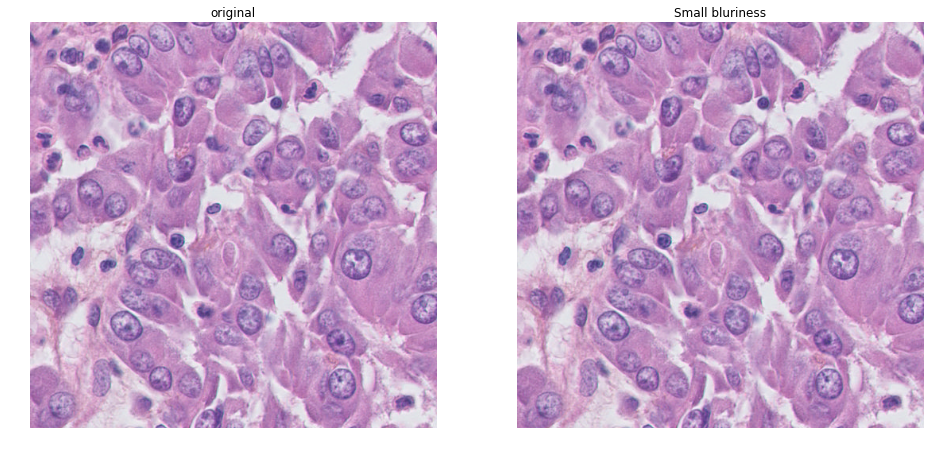

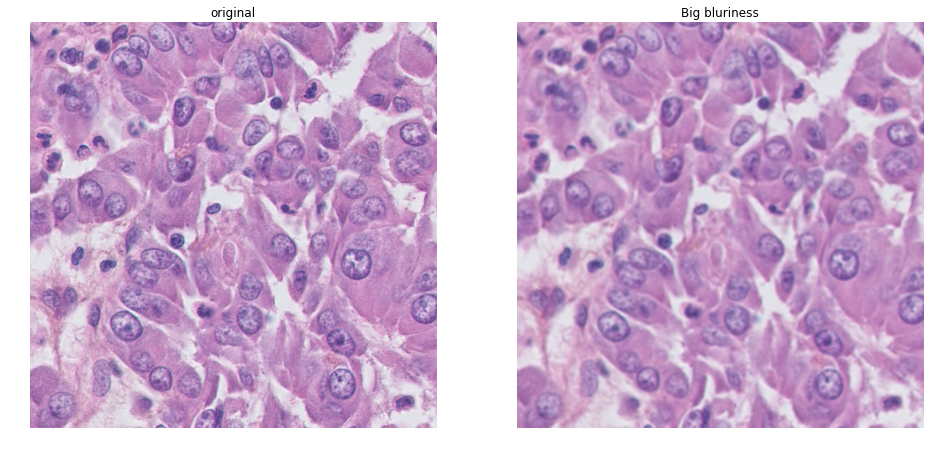

In [11]:
from scipy.ndimage.filters import gaussian_filter

blur = cv2.blur(sample,(1,1))
plot_comparison(sample, blur, "Small bluriness")

blur = cv2.blur(sample,(4,4))
plot_comparison(sample, blur, "Big bluriness")

# Elastic deformation

In [8]:
def grid(rows,cols,num_points):
    ### returns a grid in the form of a stacked array x is 0 and y is 1
    src_cols = np.linspace(0, cols, num_points)
    src_rows = np.linspace(0, rows, num_points)
    src_rows, src_cols = np.meshgrid(src_rows, src_cols)
    src = np.dstack([src_cols.flat, src_rows.flat])[0]
    return src


/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


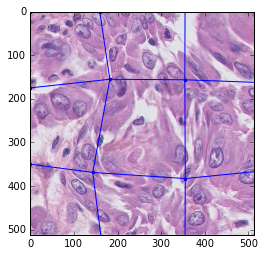

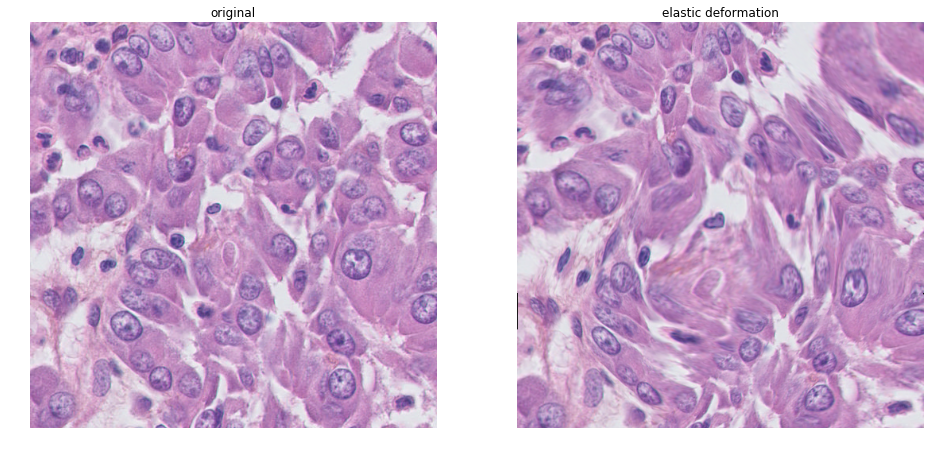

In [9]:
from skimage.transform import PiecewiseAffineTransform, warp

image = sample.copy()
rows, cols = image.shape[0], image.shape[1]

mu = 0
sigma = 30
num_points = 4

src = grid(rows, cols, num_points)
# add sinusoidal oscillation to row coordinates
dst_rows = src[:, 1] - sigma * np.random.randn(src.shape[0]) + mu
dst_cols = src[:, 0] - sigma * np.random.randn(src.shape[0]) + mu

## Delimiting points to the grid space
for point_ind in range(src.shape[0]):
    dst_rows[point_ind] = min(max(dst_rows[point_ind],0),rows)
    dst_cols[point_ind] = min(max(dst_cols[point_ind],0),cols)

#dst_rows *= 1.5
#dst_rows -= 1.5 * 50
dst = np.vstack([dst_cols, dst_rows]).T


tform = PiecewiseAffineTransform()
tform.estimate(src, dst)

#out_rows = image.shape[0] - 1.5 * 50
out_rows = rows
out_cols = cols
out = warp(image, tform, output_shape=(out_rows, out_cols))

fig, ax = plt.subplots()
ax.imshow(out)
ax.plot(tform.inverse(src)[:, 0], tform.inverse(src)[:, 1], '.b')
for i in range(num_points):
    
    hori = np.array([ j * num_points + i for j in range(num_points)])
    vert = np.array([ i * num_points + j for j in range(num_points)])
    #print "one"
    x_one = [max(el,0) for el in tform.inverse(src)[hori, 0]]
    for i in range(len(x_one)):
        if i>len(x_one)/2:
            if x_one[i] == 0:
                x_one[i] = cols
    x_two = [el for el in tform.inverse(src)[hori, 1] if el!=-1]
    x_two_mean = np.mean(x_two)
    x_two = [el if el!=-1 else x_two_mean for el in tform.inverse(src)[hori, 1]]
    
    #print tform.inverse(src)[hori, 0], tform.inverse(src)[hori, 1]
    #print "one bis"
    #print x_one, x_two
    #print "two"
    #print tform.inverse(src)[vert, 0], tform.inverse(src)[vert, 1]
    
    y_one = [max(el,0) for el in tform.inverse(src)[vert, 1]]
    for i in range(len(y_one)):
        if i>len(y_one)/2:
            if y_one[i] == 0:
                y_one[i] = rows
    y_two = [el for el in tform.inverse(src)[vert, 0] if el!=-1]
    y_two_mean = np.mean(y_two)
    y_two = [el if el!=-1 else y_two_mean for el in tform.inverse(src)[vert, 0]]
    
    
    #ax.plot(tform.inverse(src)[hori, 0], tform.inverse(src)[hori, 1], '-b')
    ax.plot(x_one, x_two, '-b')
    #ax.plot(tform.inverse(src)[vert, 0], tform.inverse(src)[vert, 1], '-b')
    ax.plot(y_two,y_one, '-b')
ax.axis((0, out_cols, out_rows, 0))
plt.show()
plot_comparison(sample,out,"elastic deformation")

# Generalized object

As one can see in the initial definition of Transf, we have an method that enables to enlarge the image via flipping the image vertically or horizontally. This is useful in the case of translation and rotation as the image will leave a lot of black gaps.

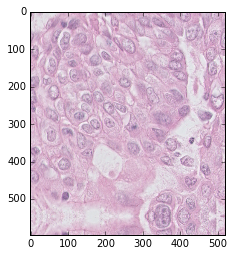

In [12]:
class Translation(Transf):
    
    def __init__(self, name, x, y, enlarge = True):
    
        Transf.__init__(self, name)
        if x < 0 :
            x = - x
            x_rev = -1
        else:
            x_rev =  1
        if y < 0 :
            y = - y
            y_rev = -1
        else:
            y_rev = 1
        
        self.params = {"x" : x, "y" : y, "rev_x": x_rev, "rev_y": y_rev, "enlarge": enlarge}
    
    def _apply_(self, image):
        
        rows, cols, channels = image.shape

        
        x = self.params['x']
        y = self.params['y']
        rev_x = self.params['rev_x']
        rev_y = self.params['rev_y']
        en_large = self.params['enlarge']
        
        if enlarge:
            big_image = self.enlarge(image, x, y)
            res = big_image[(x + rev_x*x):(rows + x + rev_x*x), (y + rev_y*y):(cols + y + rev_y*y),:]
        else:
            M = np.float32([[1,0,(x * rev_x * -1)],[0,1,(y * rev_y * -1)]])
            res = cv2.warpAffine(image, M, (cols,rows))
        return res
    
test_translation = Translation("trans", 100, 50)
tttt = test_translation._apply_(sample)
plt.imshow(tttt)
plt.show()


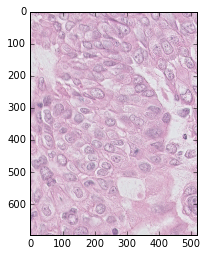

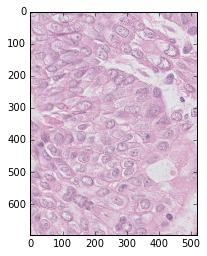

In [17]:
class Rotation(Transf):
    
    def __init__(self, name, deg, enlarge = True):

        Transf.__init__(self, name)
        self.params = {"deg" : deg, "enlarge" : enlarge}
    
    def _apply_(self, image):
        
        rows, cols, channels = image.shape

        deg = self.params['deg']
        enlarge = self.params['enlarge']
        if enlarge:
            ### this part could be better adjusted
            x = int(rows * (2 - 1.414213)/1.414213) 
            y = int(cols * (2 - 1.414213)/1.414213)

            z = max(x, y)
            big_image = self.enlarge(image, z, z)

            b_rows, b_cols, b_channels = big_image.shape
            M = cv2.getRotationMatrix2D((b_cols/2,b_rows/2),deg,1)
            dst = cv2.warpAffine(big_image,M,(b_cols,b_rows))
            res = dst[z:(z+rows),z:(z+cols),:]
        else:
            M = cv2.getRotationMatrix2D((cols/2,rows/2),30,1)
            res = cv2.warpAffine(sample,M,(cols,rows))
        return res


    
test_rotation = Rotation("rot", 30)
tttt = test_rotation._apply_(sample)
plt.imshow(tttt)
plt.show()

test_rotation = Rotation("rot", 60)
tttt = test_rotation._apply_(sample)
plt.imshow(tttt)
plt.show()

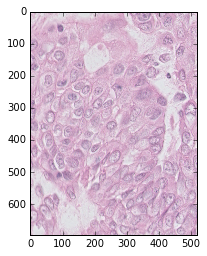

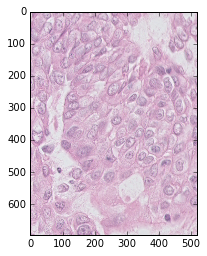

In [20]:
class Flip(Transf):
    
    def __init__(self, name, hori):
        if hori != 0 and hori!= 1:
            print "you must give a integer, your parameter is ignored"
        Transf.__init__(self, name)
        self.params = {"hori" : hori}
    
    def _apply_(self, image):
        
        hori = self.params["hori"]
        if hori == 1:
            res = flip_horizontal(image)
        else:
            res = flip_vertical(image)
        
        return res
    
test_Flip = Flip("flip", 1)
tttt = test_Flip._apply_(sample)
plt.imshow(tttt)
plt.show()

test_Flip = Flip("flip", 0)
tttt = test_Flip._apply_(sample)
plt.imshow(tttt)
plt.show()

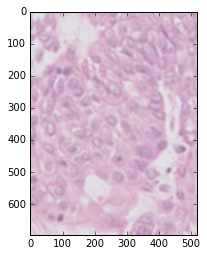

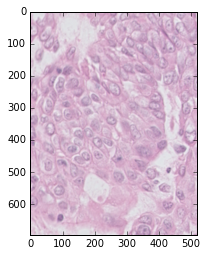

In [23]:
class OutOfFocus(Transf):
    
    def __init__(self, name, sigma):
        Transf.__init__(self, name)
        self.params = {"sigma" : sigma}
    
    def _apply_(self, image):
        
        sigma = self.params["sigma"]
        res = cv2.blur(image, (sigma, sigma))
    
        return res
    
test_OutOfFocus = OutOfFocus("OutOfFocus", 10)
tttt = test_OutOfFocus._apply_(sample)
plt.imshow(tttt)
plt.show()


test_OutOfFocus = OutOfFocus("OutOfFocus", 5)
tttt = test_OutOfFocus._apply_(sample)
plt.imshow(tttt)
plt.show()

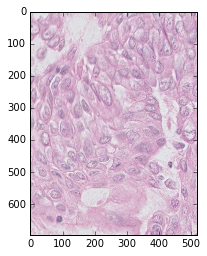

In [27]:
class ElasticDeformation(Transf):
    def __init__(self, name, mu, sigma, num_points):
        Transf.__init__(self, name)
        self.params = { "mu" : mu, "sigma" : sigma, "num_points": num_points}
        
    def grid(self, rows, cols, num_points):
        ### returns a grid in the form of a stacked array x is 0 and y is 1
        src_cols = np.linspace(0, cols, num_points)
        src_rows = np.linspace(0, rows, num_points)
        src_rows, src_cols = np.meshgrid(src_rows, src_cols)
        src = np.dstack([src_cols.flat, src_rows.flat])[0]
        return src

    def _apply_(self, image):
        
        mu = self.params["mu"]
        sigma = self.params["sigma"]
        num_points = self.params["num_points"]
        
        res = image.copy()
        rows, cols = image.shape[0], image.shape[1]

        src = grid(rows, cols, num_points)
        # add gaussian displacement to row coordinates
        dst_rows = src[:, 1] - sigma * np.random.randn(src.shape[0]) + mu
        dst_cols = src[:, 0] - sigma * np.random.randn(src.shape[0]) + mu

        ## Delimiting points to the grid space
        for point_ind in range(src.shape[0]):
            dst_rows[point_ind] = min(max(dst_rows[point_ind],0),rows)
            dst_cols[point_ind] = min(max(dst_cols[point_ind],0),cols)


        dst = np.vstack([dst_cols, dst_rows]).T


        tform = PiecewiseAffineTransform()
        tform.estimate(src, dst)

        out_rows = rows
        out_cols = cols
        res = warp(image, tform, output_shape=(out_rows, out_cols))
        
        return res
    
test_ElasticDeformation = ElasticDeformation("ElasticDeformation", 0, 30, 16)
tttt = test_ElasticDeformation._apply_(sample)
plt.imshow(tttt)
plt.show()